# Step 1: Repeat the Saez paper with Kleven-Best data

### Set up the iteration procedure

In [1]:
# Load libraries
using Parameters
using Plots
using Trapz
using NumericalIntegration
using SpecialFunctions
using Interpolations
using TimerOutputs
using JLD2
using Peaks
using DataFrames
using Statistics
using CSV

In [2]:
# Add libraries
# using Pkg
# Pkg.add("Peaks")

In [3]:
# Import Kleven-Best data from JLD2
# Make the primitives (data) struct
@with_kw struct Prims_struct
    z            # Income
    n            # Ability
    fn           # PDF of ability
    ntop         # Number of bins       
end;


In [4]:
# Set some parameters through a params struct
# Move γ, e into params
@with_kw struct Params_struct
    γ ::Int64            # SWF inequality aversion parameter
    e ::Float64          # Elasticity ε = 1/k
    k ::Int64 = 1/e      # Parametrizes elasticity ε (FINISH: Necessary?)
    R ::Int64            # Exogenous per-person revenue requirement
end;


In [5]:
# Define the inner loop
function inner_loop(prims, params, τ, T0, λ, SWF, Tax)
    # Utility
    u = -T0 .+ cumul_integrate(prims.n, ((1 .- τ).^(1+params.e))/(1+params.e))
    #println(u)
    # Copy the old variables
    λ0 = copy(λ)
    SWF0 = copy(SWF)
    Tax0 = copy(Tax)
    # MVPF
    λ = trapz(prims.n, (u .^ -params.γ) .* prims.fn)
    # RHS of the optimal tax formula
    ABmat = (cumul_integrate(prims.n, (u.^-params.γ/λ .- 1).*prims.fn) ./
             (prims.n .* prims.fn)) * params.k
    # Update τ
    τ_new = ABmat ./ (1 .+ ABmat)
    # Update the government optimization variables
    z_new = prims.n .* (1 .- τ_new) .^ params.e
    c = u .+ prims.n.*((z_new./prims.n).^(params.k+1))/(params.k+1)
    T = z_new - c
    
    Tax = trapz(prims.n, T .* prims.fn)
    SWF = trapz(prims.n, digamma.(u) .* prims.fn)
    
    return τ_new, λ, λ0, SWF, SWF0, Tax, Tax0
end

inner_loop (generic function with 1 method)

In [6]:
## Define the outer loop
function outer_loop(prims, params)
    # Iterate over these variables of interest
    τ = 0.2*ones(prims.ntop) # Tax rate
    T0 = -10000 # Negative income tax
    
    # Iteration variables
    dTax = 10000
    outer_iter = 0
    
    # Iterate through the inner optimization loop
    while abs(dTax) > 1
        # Update outer loop variables
        outer_iter += 1
        T0 = T0 - dTax # Adjuest this if necessary
        
        # Create innter loop variables
        λ = 1 # Marginal value of public funds
        λ0 = 0
        SWF = 1 # SWF value
        SWF0 = 0
        Tax = 1 # Tax revenue
        Tax0 = 0
        
        # Iterate through the inner loop
        inner_iter = 0
        while abs(λ0 - λ) > 0.0001 ||
        abs(SWF0 - SWF) > 0.0001 ||
        abs(Tax0 - Tax) > 0.0001
            # Run the inner loop
            inner_iter += 1
            τ, λ, λ0, SWF, SWF0, Tax, Tax0 = 
                inner_loop(prims, params, τ, T0, λ, SWF, Tax)
            #println(Tax)
        end
        dTax = Tax - params.R
        #println(inner_iter)
        println("Outer iter:", outer_iter, " dTax:", dTax, " Tax:", Tax)
        flush(stdout)
    end
    return τ, T0, dTax
end

outer_loop (generic function with 1 method)

### Test with Saez data

In [7]:
# Test with Saez data
# Load the JLD file
saez_jld = load("data/saez-data.jld2");

# Create the struct objects
saez_prims = Prims_struct(z = saez_jld["z"], n=saez_jld["n"], fn=saez_jld["fn"], 
    ntop=length(saez_jld["n"]));
saez_params = Params_struct(γ = saez_jld["γ"], e = saez_jld["e"], R = saez_jld["R"]);

In [8]:
# Run with Saez data
saez_τ, saez_T0, saez_dTax = outer_loop(saez_prims, saez_params);

Outer iter:1 dTax:-12935.027590589629 Tax:-8935.027590589629
Outer iter:2 dTax:2009.4246216399597 Tax:6009.42462163996
Outer iter:3 dTax:-415.970177107728 Tax:3584.029822892272
Outer iter:4 dTax:81.21242794073078 Tax:4081.212427940731
Outer iter:5 dTax:-16.038136265234698 Tax:3983.9618637347653
Outer iter:6 dTax:3.1601273501792093 Tax:4003.160127350179
Outer iter:7 dTax:-0.6229450709311095 Tax:3999.377054929069


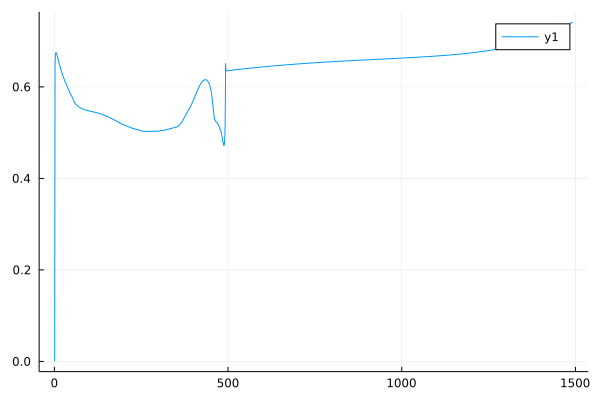

In [9]:
plot(saez_τ)

## Run with Best-Kleven data

### 1: $\gamma = 1$

In [10]:
# Run with Best-Kleven data
# Load the JLD file
bk_jld = load("data/zprimitives2.jld2");

# Create the struct objects
bk_prims = Prims_struct(z=bk_jld["z"], n=bk_jld["n"], fn=bk_jld["fn"], ntop=bk_jld["ntop"]);
bk_params = Params_struct(γ=1, e=bk_jld["e"], R=4000);

In [11]:
# Run with Best-Kleven data
bk_τ, bk_T0, bk_dTax = outer_loop(bk_prims, bk_params)

Outer iter:1 dTax:-1477.0510142701837 Tax:2522.9489857298163
Outer iter:2 dTax:276.77002246077245 Tax:4276.770022460772
Outer iter:3 dTax:-52.88100828006418 Tax:3947.118991719936
Outer iter:4 dTax:10.066237702745639 Tax:4010.0662377027456
Outer iter:5 dTax:-1.9175094890156288 Tax:3998.0824905109844
Outer iter:6 dTax:0.3652688095198755 Tax:4000.36526880952


([0.0, 0.01716304512236239, 0.03324002671990884, 0.04833435892141611, 0.0625370803714593, 0.07592864676369424, 0.0885804186769942, 0.10055590352525505, 0.11191179782008377, 0.12269886629637569  …  0.11233121579725809, 0.09969845096546737, 0.08650134929104338, 0.07270818160987452, 0.058284888596116836, 0.043194857416333374, 0.027398671858262055, 0.010853832206137096, -0.006485559474583887, -0.024669153703762974], -18754.986728124255, 0.3652688095198755)

In [12]:
# Plot results with Best-Kleven data
#bk_n0 = findmaxima(bk_τ)[1][last] # Start plot here, first local max
bk_n0 = findmax(bk_τ)[2] # Global max
bk_nend = 978 # Taken from Best-Kleven replication package, possibly adjust later

978

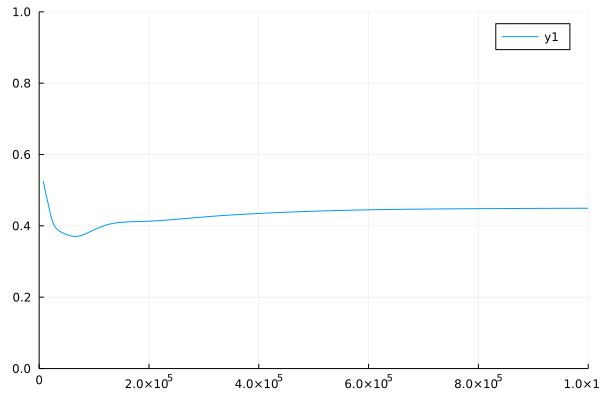

In [13]:
plot(bk_prims.z[bk_n0:bk_nend], bk_τ[bk_n0:bk_nend],
     xlims = (0, 1e6), ylims = (0, 1))

#### Figure 1

Graph the MTR and the ATR on the same plot.

In [14]:
# Find the ATR
bk_zdiff = diff(bk_prims.z);
pushfirst!(bk_zdiff, bk_prims.z[1]);
bk_T = cumsum(bk_τ .* bk_zdiff) .+ bk_T0
bk_ATR = bk_T ./ bk_prims.z;

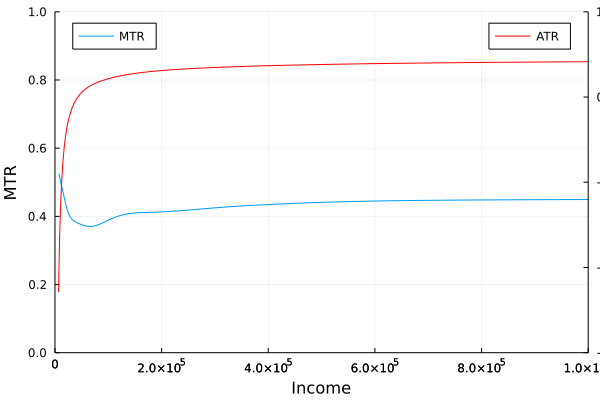

In [43]:
# Plot
plot(bk_prims.z[bk_n0:bk_nend], bk_τ[bk_n0:bk_nend],
     xlims = (0, 1e6), ylims = (0, 1), 
     label = "MTR", legend =:topleft, xlab = "Income", ylab = "MTR")
plot!(twinx(),bk_prims.z[bk_n0:bk_nend], bk_ATR[bk_n0:bk_nend],
     xlims = (0, 1e6), ylims = (-3, 1), label = "ATR", 
     legend =:topright, color = "red", ylab = "ATR")

# savefig("figs/MTR_ATR_no_educ")

#### Figure 2

Graph $f_0(\omega_0 - E[\omega_0]), f_z(z - E[z]),$ and $f_T((z - T(z)) - E[z - T(z)])$ on the same plot.

In [16]:
# Function that smoothes distributions
# (Same procedure as in Saez)
function smooth_dist(dist, niter)
    old = copy(dist)
    new = copy(dist)
    ndata = length(dist)
    for i in 1:niter
        for j in 2:ndata-1
            new[j] = 0.3*old[j-1] + 0.4*old[j] + 0.3*old[j+1]
        end
        old = copy(new)
    end
    return new
end;

In [17]:
# Load distributions from the original data
bk_dta = dta = Float64.(DataFrame(load("data/new_dta/psid/psidtaxsim_20mil.dta")));

In [18]:
# Smooth the income distribution
# So it's not much messier the ability distribution
# (Using the same number of iterations as smoothing the ability distribution)
bk_hz = smooth_dist(bk_dta.hz, 500);
bk_z = smooth_dist(bk_dta.z, 500);
bk_Hz = smooth_dist(bk_dta.Hz, 500);

In [19]:
# Find the net-of-tax income distribution
bk_Thz = bk_prims.z - bk_T;

In [20]:
# Adjust everything to be the region we care about
fn_plot = bk_prims.fn[bk_n0:bk_nend];
hz_plot = bk_hz[bk_n0:bk_nend];
n_plot = (bk_prims.n .- mean(bk_prims.n))[bk_n0:bk_nend];
z_plot = (bk_prims.z .- mean(bk_prims.z))[bk_n0:bk_nend];
Tz_plot = (bk_Thz .- mean(bk_Thz))[bk_n0:bk_nend];

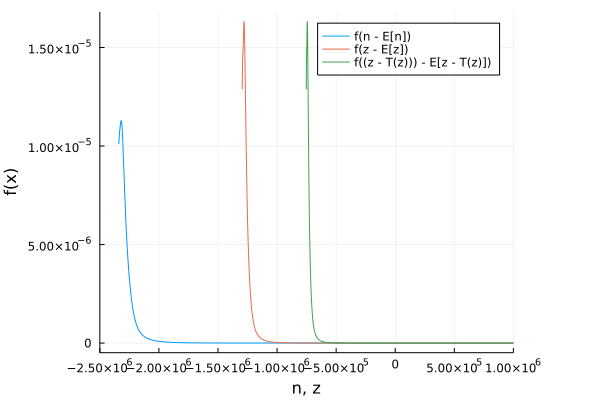

In [45]:
plot(n_plot, fn_plot,
     xlims = (-2.5e6, 1e6),
     right_margin=20Plots.mm, xlab = "n, z", ylab = "f(x)",
     label = "f(n - E[n])")
plot!(z_plot, hz_plot, 
     label = "f(z - E[z])")
plot!(Tz_plot, hz_plot,
     label = "f((z - T(z))) - E[z - T(z)])")

# savefig("figs/fx_no_educ")

## Extra charts

From 12/1/22 meeting, to compare the MTR and income distribution between this data and the Best-Kleven data.

### 1: Top right panel of Best-Kleven Figure 3

In [22]:
# Open the original dataset from Matlab
bk_matlab = DataFrame(CSV.File("data/d0gamma1output.csv", header = false));
rename!(bk_matlab, [:z, :τ_o, :τ_y]);

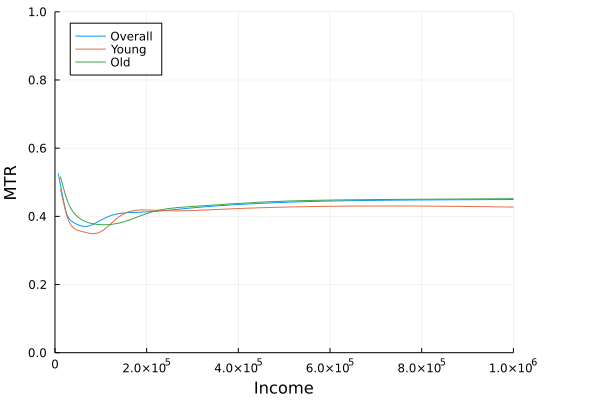

In [30]:
# Plot all on the same chart
plot(bk_prims.z[bk_n0:bk_nend], bk_τ[bk_n0:bk_nend],
     xlims = (0, 1e6), ylims = (0, 1), right_margin=20Plots.mm,
     label = "Overall", legend =:topleft, xlab = "Income", ylab = "MTR")
plot!(bk_matlab.z[bk_n0:bk_nend], bk_matlab.τ_y[bk_n0:bk_nend],
     xlims = (0, 1e6), ylims = (0, 1), right_margin=20Plots.mm,
     label = "Young", legend =:topleft, xlab = "Income", ylab = "MTR")
plot!(bk_matlab.z[bk_n0:bk_nend], bk_matlab.τ_o[bk_n0:bk_nend],
     xlims = (0, 1e6), ylims = (0, 1), right_margin=20Plots.mm,
     label = "Old", legend =:topleft, xlab = "Income", ylab = "MTR")

# savefig("figs/tax_comparison")

### 2: Income distributions

In [24]:
# Load more detailed income data from Matlab
bk_matlab_dist = DataFrame(CSV.File("data/statae050.csv", header = false));
rename!(bk_matlab_dist, [:z, :Hzy, :hzy, :Hzo, :hzo, :mtrz, :ω, :jω, :Jω, :dtapars]);

In [25]:
# Smooth distributions
bk_matlab_z = smooth_dist(bk_matlab_dist.z, 500);
bk_matlab_Hzy = smooth_dist(bk_matlab_dist.Hzy, 500);
bk_matlab_hzy = smooth_dist(bk_matlab_dist.hzy, 500);
bk_matlab_Hzo = smooth_dist(bk_matlab_dist.Hzo, 500);
bk_matlab_hzo = smooth_dist(bk_matlab_dist.hzo, 500);

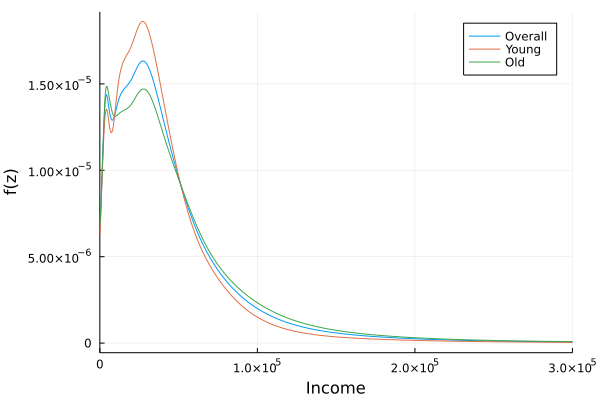

In [37]:
plot(bk_z, bk_hz, xlims = (0, 3e5),
    label = "Overall", right_margin=5Plots.mm,
    xlab = "Income", ylab = "f(z)")
plot!(bk_matlab_z, bk_matlab_hzy,
    label = "Young")
plot!(bk_matlab_z, bk_matlab_hzo,
    label = "Old")

# savefig("figs/z_comparison")

### 3: Hazard ratio: $\frac{1-H(z)}{zh(z)}$

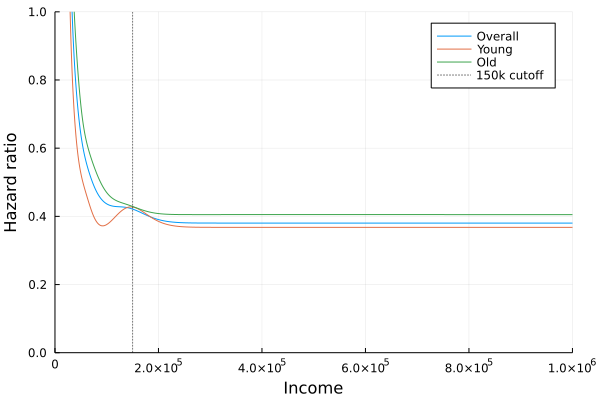

In [48]:
plot(bk_z, (1 .- bk_Hz)./(bk_z .* bk_hz),
    xlim = (0, 1e6), ylim = (0, 1), label = "Overall",
    xlab = "Income", ylab = "Hazard ratio", right_margin=5Plots.mm)
plot!(bk_matlab_z, 
    (1 .- bk_matlab_Hzy)./(bk_matlab_z .* bk_matlab_hzy),
    label = "Young")
plot!(bk_matlab_z, 
    (1 .- bk_matlab_Hzo)./(bk_matlab_z .* bk_matlab_hzo),
    label = "Old")
vline!([150000], color = "black", style = :dot,
        label = "150k cutoff")

# savefig("figs/hazard_comparison")